In [1]:
%matplotlib inline


=============================================================================
Manifold learning on handwritten digits: Locally Linear Embedding, Isomap...
=============================================================================

An illustration of various embeddings on the digits dataset.

The RandomTreesEmbedding, from the :mod:`sklearn.ensemble` module, is not
technically a manifold embedding method, as it learn a high-dimensional
representation on which we apply a dimensionality reduction method.
However, it is often useful to cast a dataset into a representation in
which the classes are linearly-separable.

t-SNE will be initialized with the embedding that is generated by PCA in
this example, which is not the default setting. It ensures global stability
of the embedding, i.e., the embedding does not depend on random
initialization.

Linear Discriminant Analysis, from the :mod:`sklearn.discriminant_analysis`
module, and Neighborhood Components Analysis, from the :mod:`sklearn.neighbors`
module, are supervised dimensionality reduction method, i.e. they make use of
the provided labels, contrary to other methods.



In [2]:
# Authors: Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2011
'''
Modified to do manifold learning on clock drawing images
'''
print(__doc__)
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from data.preprocess import *
data = preprocess(path='../data/raw/CD_PD.mat')


Modified to do manifold learning on clock drawing images



In [27]:
X = np.zeros(shape=(196,10000))
clk_img = np.zeros(shape=(196,100,100))
for i in range(196):
    X[i] = np.ravel(get_image(data['x'][i], data['y'][i],100,100))
    clk_img[i] = get_image(data['x'][i], data['y'][i],100,100)
y1 = list(data['clock_drawing'])
y2 = list(data['diagnosis'])
n_samples, n_features = X.shape
n_neighbors = 30

<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarra

<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarra

In [123]:
# ----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X,y,title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(20,15))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        name = str(i)
        lb='positive'
        color='g'
        if y[i] == 0:
            name=str(i)
            color='r'
            lb='negative'
        if i == 0:
            plt.scatter(X[i, 0], X[i, 1], color=color,s=10+3*data['duration'][i], label=lb)
        else:
            plt.scatter(X[i, 0], X[i, 1], color=color,s=10+3*data['duration'][i]) #no label
        plt.text(X[i, 0], X[i, 1]+0.01, name,
                 color=plt.cm.Set1(y[i]),
                 fontdict={'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 1e-1:
                # don't show points that are too close
                continue
#             shown_images = np.r_[shown_images, [X[i]]]
#             imagebox = offsetbox.AnnotationBbox(
#                 offsetbox.OffsetImage(clk_img[i], cmap=plt.cm.gray_r),
#                 X[i])
#             ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.legend()

Computing t-SNE embedding


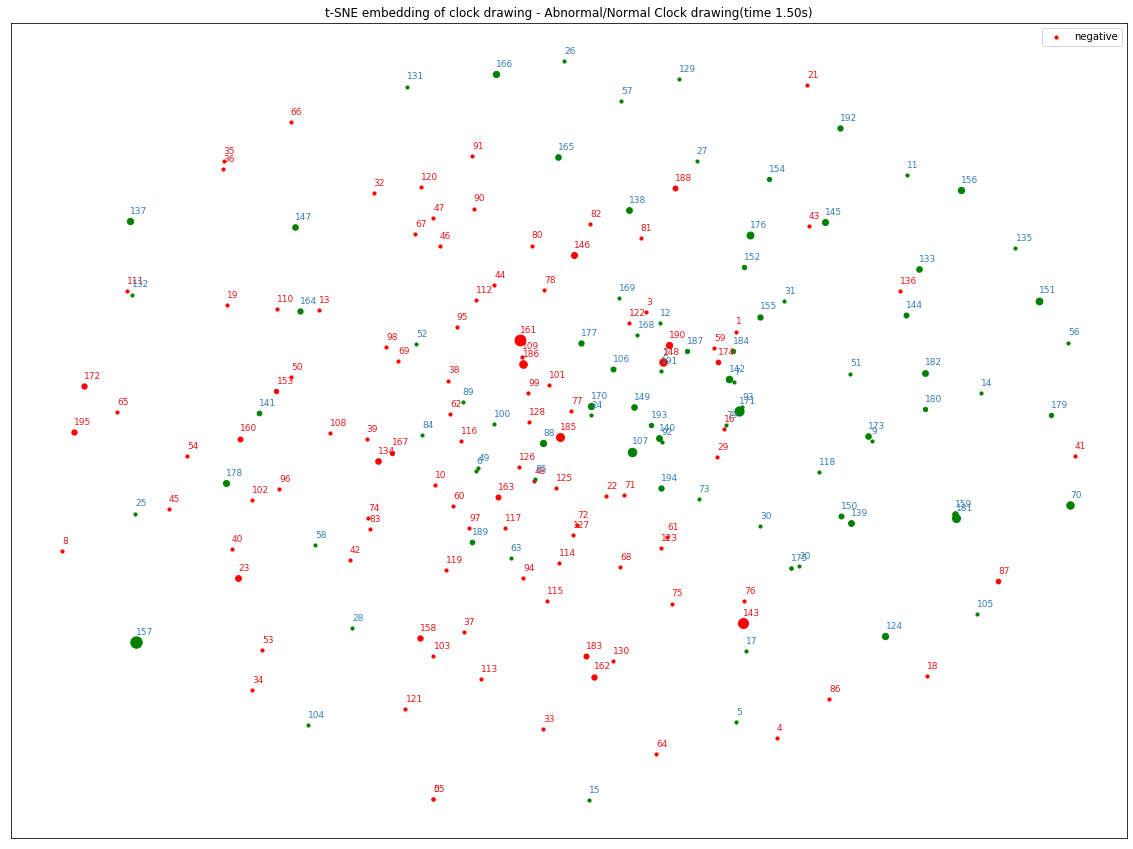

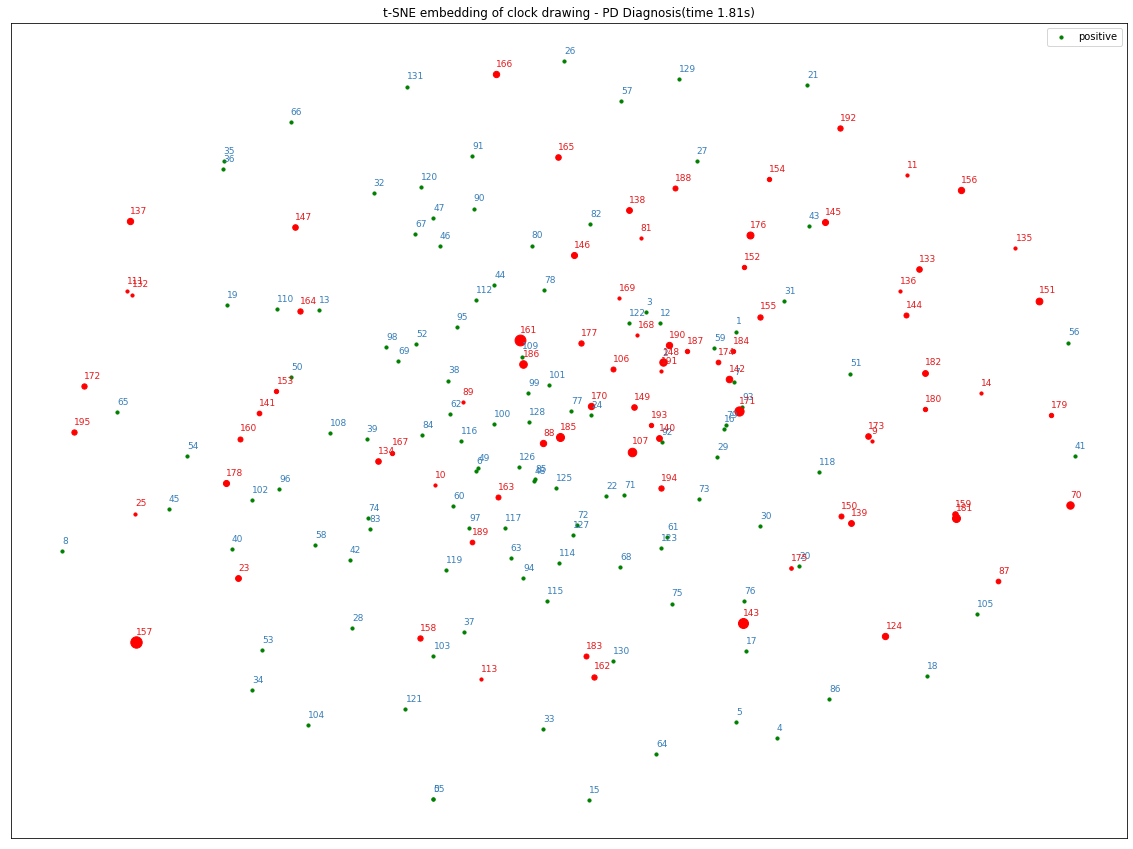

In [124]:
# y = np.array(y1)
# # ----------------------------------------------------------------------
# # Random 2D projection using a random unitary matrix
# print("Computing random projection")
# rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
# X_projected = rp.fit_transform(X)
# plot_embedding(X_projected,y, "Random Projection of the digits")


# #----------------------------------------------------------------------
# # Projection on to the first 2 principal components

# print("Computing PCA projection")
# t0 = time()
# X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
# plot_embedding(X_pca,y,
#                "Principal Components projection of the digits (time %.2fs)" %
#                (time() - t0))

# # ----------------------------------------------------------------------
# # Projection on to the first 2 linear discriminant components

# print("Computing Linear Discriminant Analysis projection")
# X2 = X.copy()
# X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
# t0 = time()
# X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
# plot_embedding(X_lda,y,
#                "Linear Discriminant projection of the digits (time %.2fs)" %
#                (time() - t0))


# # ----------------------------------------------------------------------
# # Isomap projection of the digits dataset
# print("Computing Isomap projection")
# t0 = time()
# X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
# print("Done.")
# plot_embedding(X_iso,y,
#                "Isomap projection of the digits (time %.2fs)" %
#                (time() - t0))


# # ----------------------------------------------------------------------
# # Locally linear embedding of the digits dataset
# print("Computing LLE embedding")
# clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
#                                       method='standard')
# t0 = time()
# X_lle = clf.fit_transform(X)
# print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
# plot_embedding(X_lle,y,
#                "Locally Linear Embedding of the digits (time %.2fs)" %
#                (time() - t0))


# # ----------------------------------------------------------------------
# # Modified Locally linear embedding of the digits dataset
# print("Computing modified LLE embedding")
# clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
#                                       method='modified')
# t0 = time()
# X_mlle = clf.fit_transform(X)
# print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
# plot_embedding(X_mlle,y,
#                "Modified Locally Linear Embedding of the digits (time %.2fs)" %
#                (time() - t0))


# # ----------------------------------------------------------------------
# # HLLE embedding of the digits dataset
# print("Computing Hessian LLE embedding")
# clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
#                                       method='hessian')
# t0 = time()
# X_hlle = clf.fit_transform(X)
# print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
# plot_embedding(X_hlle,y,
#                "Hessian Locally Linear Embedding of the digits (time %.2fs)" %
#                (time() - t0))


# # ----------------------------------------------------------------------
# # LTSA embedding of the digits dataset
# print("Computing LTSA embedding")
# clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
#                                       method='ltsa')
# t0 = time()
# X_ltsa = clf.fit_transform(X)
# print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
# plot_embedding(X_ltsa,y,
#                "Local Tangent Space Alignment of the digits (time %.2fs)" %
#                (time() - t0))

# # ----------------------------------------------------------------------
# # MDS  embedding of the digits dataset
# print("Computing MDS embedding")
# clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
# t0 = time()
# X_mds = clf.fit_transform(X)
# print("Done. Stress: %f" % clf.stress_)
# plot_embedding(X_mds,y,
#                "MDS embedding of the digits (time %.2fs)" %
#                (time() - t0))

# # ----------------------------------------------------------------------
# # Random Trees embedding of the digits dataset
# print("Computing Totally Random Trees embedding")
# hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
#                                        max_depth=5)
# t0 = time()
# X_transformed = hasher.fit_transform(X)
# pca = decomposition.TruncatedSVD(n_components=2)
# X_reduced = pca.fit_transform(X_transformed)

# plot_embedding(X_reduced,y,
#                "Random forest embedding of the digits (time %.2fs)" %
#                (time() - t0))

# # ----------------------------------------------------------------------
# # Spectral embedding of the digits dataset
# print("Computing Spectral embedding")
# embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
#                                       eigen_solver="arpack")
# t0 = time()
# X_se = embedder.fit_transform(X)

# plot_embedding(X_se,y,
#                "Spectral embedding of the digits (time %.2fs)" %
#                (time() - t0))

# ----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=42, perplexity=30,n_iter=10000,learning_rate=5)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,y1,
               "t-SNE embedding of clock drawing - Abnormal/Normal Clock drawing(time %.2fs)" %
               (time() - t0))

plot_embedding(X_tsne,y2,
               "t-SNE embedding of clock drawing - PD Diagnosis(time %.2fs)" %
               (time() - t0))

# # ----------------------------------------------------------------------
# # NCA projection of the digits dataset
# print("Computing NCA projection")
# nca = neighbors.NeighborhoodComponentsAnalysis(n_components=2, random_state=0)
# t0 = time()
# X_nca = nca.fit_transform(X, y)

# plot_embedding(X_nca,y,
#                "NCA embedding of the digits (time %.2fs)" %
#                (time() - t0))

# plt.show()